In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import cirpy
from urllib.request import urlopen
from urllib.parse import quote
import pubchempy as pcp
from matplotlib import colors
from requests import get
from bs4 import BeautifulSoup
from chemspipy import ChemSpider
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from rdkit.Chem.inchi import MolToInchi
from rdkit.Chem import MolFromSmiles

In [2]:
octane = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\cleaned_octane_database.csv')
comb_h = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\comb_heat.csv')
boil_p = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\boiling_point.csv')
densit = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\density.csv')
entr_h = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\raw_data\entropy_heat_capacity.csv')
auto_t = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\autoignition_temp.csv')

comb_h = comb_h.rename(columns={'Smiles':'SMILES'})
boil_p = boil_p.rename(columns={'Smiles':'SMILES'})
boil_p = boil_p.rename(columns={'Boiling_point_K':'boiling_point_K'})
densit = densit.rename(columns={'Smiles':'SMILES'})

print(densit.shape)

(543, 4)


In [4]:
len(octane)

492

### Find the number of missing physical properties data between octane database and 


In [3]:
for df,name in zip([comb_h,boil_p,densit,entr_h,auto_t],['combustion heat','boiling point','density','entropy','autoig. temp']):
    print('Number of missing values for ' + name +' = {}'.format(pd.merge(octane,df,how='left',on='SMILES').iloc[:,-1].isnull().sum()))


Number of missing values for combustion heat = 443
Number of missing values for boiling point = 443
Number of missing values for density = 509
Number of missing values for entropy = 403
Number of missing values for autoig. temp = 396


In [5]:
len(set(octane['SMILES'].values)-set(comb_h['SMILES'].values))

443

# Complexity and XLogP

In [64]:
def X_LogP_Complexity(row):
    smi  = row['SMILES']
    prop = pcp.get_properties(['Complexity', 'XLogP'], smi, 'smiles', as_dataframe=False)[0]
    return prop['Complexity'],prop['XLogP']

In [65]:
octane[['Complexity','XLogP']] = octane.apply(X_LogP_Complexity, axis=1, result_type="expand")

In [66]:
#save results 

octane.to_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\cleaned_octane_database.csv')

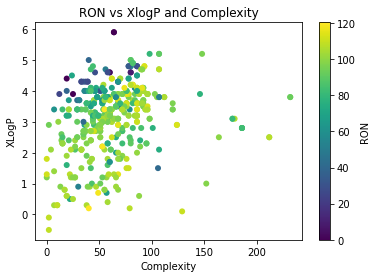

In [67]:
plt.scatter(octane['Complexity'],octane['XLogP'],edgecolors='none',c=octane['y'])
plt.xlabel('Complexity')
plt.ylabel('XLogP') 
plt.title('RON vs XlogP and Complexity')
plt.colorbar(label='RON')
plt.show()

## Functions to clean KNOVEL datasets 

In [3]:
def to_float(x):
    if x=='""' or x =='':
        return None
    else:
        return float(x[1:-1])

    
def string_float(x,idx):
    if idx ==1:
        return str(x[1:-1])
    else:
        return to_float(x)
    return df


def bracket(str_):
    if '(' in str_:
        name = str_.split('(')[0]
        return name
    else:
        return str_


def clean_df(link_,header,skiprows,col):
    
    df     = pd.read_csv(link_,skiprows=skiprows,header=None,sep='delimiter')
    df.drop(df.tail(3).index,inplace=True)
    
    def func_row(row):
        vals_    = row.values[0].split(';')[:len(col)]
        return [string_float(x,idx) for x,idx in zip(vals_,col)]
    
    df[header] = df.apply(func_row,axis=1,result_type='expand')
    
    df = df.drop(0,axis=1)
    
    return df 

def cas_to_smiles(x):
    try:
        query = cirpy.resolve(x, 'smiles')
        if query is None:
            return None
        else:
            return query
    except:
        return None
    
    
def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return None
    
    
def name_to_smiles(name):
    try:
        smiles = pcp.get_compounds(name, 'name')[0].canonical_smiles
        return smiles
    except:
        return None

cs = ChemSpider('qGbVRsz4Lij2NYY5e1Zb9pYphSAiHLkv')
    
def spider_CAS_to_smiles(x):
    '''Input CAS number
    Output [smiles*]'''
    try: 
        smiles_list = []
        for result in cs.search(x):
            lost_compound = cs.get_compound(result.record_id)
            smiles_list.append(lost_compound.smiles)
        return smiles_list[0]
    except:
        return None

In [14]:
compound = cs.get_compound(2157)

In [15]:
def F_to_C(x):
    return (x-32)*(5/9)

In [4]:
'''Web scraping adopted from 
https://www.linkedin.com/pulse/scraping-nist-webbook-python-extract-antoine-equation-oscar-fabi%C3%A1n'''

def get_response(url):
    return get(url).content


def nist_bp(cid):
    '''Input: PubChem CID
      Output: Boiling point and measuremnt error'''
    
    try:
        InChI        = pcp.Compound.from_cid(cid).inchi.split('=')[1]
        url          = str.format('https://webbook.nist.gov/cgi/cbook.cgi?InChI={0}&Mask=4',InChI)
        html         = BeautifulSoup(get_response(url), 'html.parser')
        table        = html.find('table', attrs={'aria-label': 'One dimensional data'})
        bp_row       = table.find_all('tr',class_='cal')[0]
        cols         = bp_row.find_all('td')
        Temp,_,error = cols[1].text.split()
        
        return float(Temp)
    except:
        return None

In [9]:
# Toluene example https://webbook.nist.gov/cgi/cbook.cgi?ID=C108883&Mask=4
nist_bp(1140)

383.8

# Reid Vapour Pressure (vapour pressure at 37.8 deg)

In [5]:
def get_html_table(SMILES):
    
    #InChI        = pcp.Compound.from_cid(cid).inchi.split('=')[1]
    InChI         = MolToInchi(MolFromSmiles(SMILES)).split('=')[1]

    # We treat the url attaching the Name variable to it.
    url = str.format('https://webbook.nist.gov/cgi/cbook.cgi?InChI={0}&Mask=4',InChI)

    # Function to get the request made, see above.
    raw_html = get_response(url)

    # Parse the html using BeautifulSoup.
    html = BeautifulSoup(raw_html, 'html.parser')

    # Extract the table that contains the data, the table has a specific
    # attributes 'aria-label' as 'Antoine Equation Parameters'.
    table = html.find('table', attrs={'aria-label': 'Antoine Equation Parameters'})

    return table

In [6]:
def get_antoine_coef(row, Temperature=310.8):
    # Function takes row of data --> takes pubchem CID ---> 
    # Obtaining the table using the get_html function showed below. Table is a
    # BeautifulSoup Object.

    try:
        #cid = row['PubChem']
        #table = get_html_table(cid)
        SMILES = row['SMILES']
        table  = get_html_table(SMILES)

        # Extract the rows from the table. Knowing what tags have an HTML table.
        # Also, knowing that the fist row with he table header does not have the
        # class attribute 'exp' so we obtain just the rows with data.
        # The find_all function from BeautifulSoup return a list
        rows = table.find_all('tr', class_='exp')


        Temperatures, As, Bs, Cs = [], [], [], []

        for row in rows:
            cols = row.find_all('td')
            As.append(float(cols[1].text))
            Bs.append(float(cols[2].text))
            Cs.append(float(cols[3].text))

            lower_lim = float(cols[0].text.replace(" ", "").split('-')[0])
            higher_lim = float(cols[0].text.replace(" ", "").split('-')[1])
            Temperatures.append([lower_lim, higher_lim])

        index = int()
        for i, interval in enumerate(Temperatures):
            if (interval[0] <= Temperature
                and Temperature <= interval[1]):
                index = i
                break
            else:
                index = None

        if index == None:
            print('Sorry, the data for the given temperature {0}K does \
                       not exist in the Data Base, Temperature')
            return None
        else:
            A = As[index]
            B = Bs[index]
            C = Cs[index]
            return 10**(A - (B / (Temperature + C)))

    except:
        return None

In [62]:
octane[['P_reid_bar']] = octane.apply(get_antoine_coef,axis=1)

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

In [63]:
print('Reid vapour pressure overlap with octane = {}'.format(octane['P_reid_bar'].notnull().sum()))

Reid vapour pressure overlap with octane = 78


Text(0.5, 1.0, 'data with Reid Vapour Pressure <0.1')

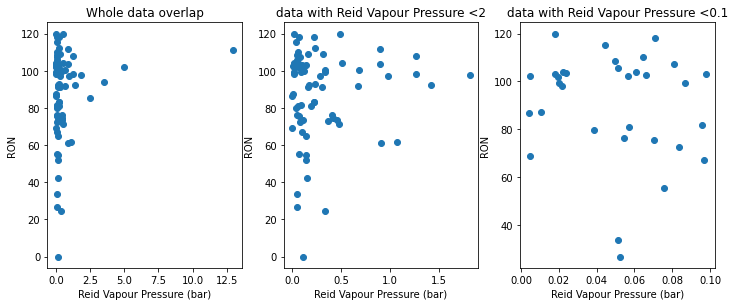

In [96]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(10, 4))
fig.tight_layout()

cond      = (octane['P_reid_bar'].notnull()) & (octane['P_reid_bar']<2)
cond2      = (octane['P_reid_bar'].notnull()) & (octane['P_reid_bar']<0.1)

ax1.scatter(octane.loc[octane['P_reid_bar'].notnull(),'P_reid_bar'],octane.loc[octane['P_reid_bar'].notnull(),'y'])
ax1.set_xlabel('Reid Vapour Pressure (bar)')
ax1.set_ylabel('RON')
ax1.set_title('Whole data overlap')

ax2.scatter(octane.loc[cond,'P_reid_bar'],octane.loc[cond,'y'])
ax2.set_xlabel('Reid Vapour Pressure (bar)')
ax2.set_ylabel('RON')
ax2.set_title('data with Reid Vapour Pressure <2')


ax3.scatter(octane.loc[cond2,'P_reid_bar'],octane.loc[cond2,'y'])
ax3.set_xlabel('Reid Vapour Pressure (bar)')
ax3.set_ylabel('RON')
ax3.set_title('data with Reid Vapour Pressure <0.1')

In [12]:
bp_data = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\boiling_point.csv')

In [14]:
bp_data.head(5)

,Unnamed: 0,SMILES,boiling_point_K
0,0,CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...,649.70
1,1,C1Cc2cccc3cccc1c23,550.54
2,2,CCOC(C)OCC,376.75
3,3,CC=O,293.55
4,4,CC(N)=O,494.30


In [24]:
bp_data['Reid_pressure'] = bp_data.apply(get_antoine_coef,axis=1)

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

In [25]:
bp_data.shape

(5549, 4)

In [28]:
bp_data.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\boiling_point.csv')

# Boiling Point and Density

###  Knovel Data for boiling point and density 

https://app.knovel.com/web/view/itable/show.v/rcid:kpYHTPPCC4/cid:kt002UT9Q2/viewerType:itble//root_slug:Physical-Properties-and-Refractive-Index/url_slug:physical-properties-refractive?b-q=Yaws%27%20Handbook%20of%20Thermodynamic%20and%20Physical%20Properties%20of%20Chemical%20Compounds&include_synonyms=no&q=Yaws%27%20Handbook%20of%20Thermodynamic%20and%20Physical%20Properties%20of%20Chemical%20Compounds&sort_on=default&start=4950&columns=1,3,4,5,6,8,10,12,13


In [97]:
files_dir    = glob.glob(r"C:\Users\zcemg08\Desktop\bp_density\*.csv")

header       = ['compound','CAS Registry No.','formula','mol_weight','freeze_point_K',\
                    'boiling_point_K','density (g/cm3)','refractive index temp.T (Â°C)',\
                           'refractive index @ T,nD']

skiprows = [0,1,2,3,4]

col      = [1,1,1,0,0,0,0,0,0]

data_knovel = pd.concat([clean_df(x,header,skiprows,col) for x in files_dir])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [98]:
data_knovel.head(2)

,compound,CAS Registry No.,formula,mol_weight,freeze_point_K,boiling_point_K,density (g/cm3),refractive index temp.T (Â°C),"refractive index @ T,nD"
0,abietic acid,514-10-3,C20H30O2,302.457,446.65,649.70,NaN,NaN,NaN
1,acenaphthene,83-32-9,C12H10,154.211,366.56,550.54,NaN,19.85,1.642


In [9]:
data_knovel['SMILES']                                    = data_knovel['CAS Registry No.'].apply(cas_to_smiles)
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['compound'].apply(CIRconvert)
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['compound'].apply(name_to_smiles)

In [14]:
'Fraction of missing SMILES rows = {}'.format(len(data_knovel[data_knovel['SMILES'].isnull()])/len(data_knovel))

'Fraction of missing SMILES rows = 0.033144862546305325'

In [15]:
data_knovel.to_csv(r'C:\Users\zcemg08\Desktop\data\bp_density_knovel.csv')

In [99]:
bp = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\bp_density_knovel.csv')

In [100]:
len(bp)+len(boil_p)

5621

### Merge loaded BP data and processed KNOVEL BP data

In [101]:
final_bp = bp[['SMILES','boiling_point_K']].merge(boil_p,on=['SMILES'],how='outer')
final_bp = final_bp.fillna(0)
final_bp.head(3)

,SMILES,boiling_point_K_x,boiling_point_K_y
0,CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...,649.70,0.0
1,C1Cc2cccc3cccc1c23,550.54,0.0
2,CCOC(C)OCC,376.75,0.0


In [102]:
def bp_(row):
    '''Priority is given to KNOVEL data, since no averaging was involved'''
    x = row[0]
    y = row[1]
    
    if x == 0:
        return y
    else:
        return x
    
final_bp['boiling_point_K'] = final_bp[list(final_bp)[1:]].apply(bp_,axis=1)
final_bp                    = final_bp[['SMILES','boiling_point_K']]

final_bp.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\boiling_point.csv')
print('Final boiling point database size = {}'.format(len(final_bp)))

Final boiling point database size = 5549


In [8]:
boil_point = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\boiling_point.csv')

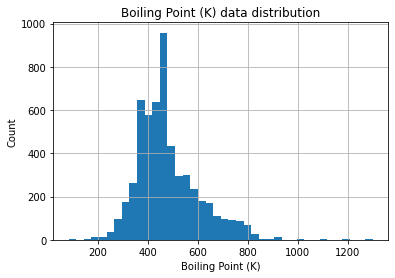

In [9]:
boil_point['boiling_point_K'].hist(bins=40)
plt.title('Boiling Point (K) data distribution')
plt.xlabel('Boiling Point (K)')
plt.ylabel('Count')
plt.show()

In [11]:
bp = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\bp_density_knovel.csv')

In [13]:
bp.shape

(5129, 11)

In [14]:
bp

,Unnamed: 0,compound,CAS Registry No.,formula,mol_weight,freeze_point_K,boiling_point_K,density (g/cm3),refractive index temp.T (Â°C),"refractive index @ T,nD",SMILES
0,0,abietic acid,514-10-3,C20H30O2,302.457,446.65,649.70,NaN,NaN,NaN,CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...
1,1,acenaphthene,83-32-9,C12H10,154.211,366.56,550.54,NaN,19.85,1.6420,C1Cc2cccc3cccc1c23
2,2,acetal,105-57-7,C6H14O2,118.176,173.15,376.75,0.8210,25.00,1.3682,CCOC(C)OCC
3,3,acetaldehyde,1975-07-13,C2H4O,44.053,150.15,293.55,0.7740,25.00,1.3283,CC=O
4,4,acetamide,60-35-5,C2H5NO,59.068,354.15,494.30,NaN,77.85,1.4274,CC(N)=O
...,...,...,...,...,...,...,...,...,...,...,...
5124,45,"2,5,7-trimethylnonane",62184-14-9,C12H26,170.338,179.50,467.15,0.7484,25.00,1.4200,CCC(C)CC(C)CCC(C)C
5125,46,"2,5,6-trimethylnonane",62184-13-8,C12H26,170.338,179.50,469.15,0.7545,25.00,1.4228,CCCC(C)C(C)CCC(C)C
5126,47,"2,3,4-trimethylnonane",62184-56-9,C12H26,170.338,179.50,473.15,0.7612,25.00,1.4261,CCCCCC(C)C(C)C(C)C
5127,48,"3,3,5-trimethylnonane",62184-19-4,C12H26,170.338,211.92,463.15,0.7548,25.00,1.4231,CCCCC(C)CC(C)(C)CC


In [16]:
bp['density (g/cm3)'].notnull().sum()

3799

### Fill octane database with above boiling point data 

In [105]:
octane['boiling_point_K']= pd.merge(octane,final_bp,on='SMILES',how='left')['boiling_point_K']

In [106]:
print('Overlap  BP values in octane data = {}'.format(octane['boiling_point_K'].notnull().sum()))

Overlap  BP values in octane data = 191


## Fill missing values by web scrapping from NIST 

In [108]:
octane.loc[octane['boiling_point_K'].isnull(),'boiling_point_K'] = octane[octane['boiling_point_K'].isnull()]['PubChem'].apply(nist_bp)

In [109]:
print('Number of missing BP values in octane data = {}'.format(octane['boiling_point_K'].isnull().sum()))

Number of missing BP values in octane data = 197


In [217]:
octane.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [218]:
data_bp = octane.loc[octane['boiling_point_K'].notnull(),['y','boiling_point_K']]

print('overlap size between octane and boiling point = {}'.format(len(data_bp)))

overlap size between octane and boiling point = 295


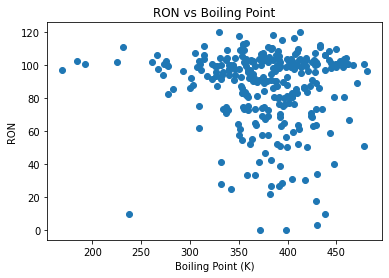

In [219]:
plt.scatter(data_bp['boiling_point_K'],data_bp['y'])
plt.xlabel('Boiling Point (K)')
plt.ylabel('RON')
plt.title('RON vs Boiling Point')
plt.show()

# Autoiginition Temperature 

### 1st folder

https://app.knovel.com/web/view/itable/show.v/rcid:kpRTCEAMQ7/cid:kt008KALU2/viewerType:itble//root_slug:Table-1-Compilation-of-AIT-autoignition-temperature-Data/url_slug:table-1-compilation-ait?b-content-type=igraph%2Citable&b-q=autoignition%20temperature&include_synonyms=no&q=autoignition%20temperature&sort_on=default&start=400&columns=1,2,3,4,5,6&sort=6&direction=DESC

In [10]:
files_auto1    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\*.csv")[1:]

header   = ['compound','lowest_rep_auto_temp_C','lowest_rep_auto_temp_F',\
          'lowest_rep_auto_temp_C_other','lowest_rep_auto_temp_F_other','reference']

col      = [1,0,0,0,0,1]

skiprows = [0,1,2,3,4,5,6,7,8,9,10]


data_auto1 = pd.concat([clean_df(x,header,skiprows,col) for x in files_auto1])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [11]:
data_auto1.head(3)

,compound,lowest_rep_auto_temp_C,lowest_rep_auto_temp_F,lowest_rep_auto_temp_C_other,lowest_rep_auto_temp_F_other,reference
0,Methane,NaN,NaN,537.0,999.0,17
1,Ethane,515.0,959.0,472.0,882.0,"2, 24"
2,Butane,372.0,702.0,450.0,842.0,"14, 20"


In [35]:
### Find SMILES column 

data_auto1['SMILES']                                   = data_auto1.iloc[:,0].apply(lambda x: name_to_smiles(bracket(x)))
data_auto1.reset_index(inplace=True)
data_auto1.loc[data_auto1['SMILES'].isnull(),'SMILES']  = data_auto1.loc[data_auto1['SMILES'].isnull(),'compound'].apply(\
                                                            lambda x: CIRconvert(bracket(x)))

In [41]:
data_auto1.to_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\auto_combine1.csv')

In [13]:
data_auto1 = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\auto_combine1.csv')

In [14]:
data_auto1.head()

,Unnamed: 0,index,compound,lowest_rep_auto_temp_C,lowest_rep_auto_temp_F,lowest_rep_auto_temp_C_other,lowest_rep_auto_temp_F_other,reference,SMILES
0,0,0,Methane,NaN,NaN,537.0,999.0,17,C
1,1,1,Ethane,515.0,959.0,472.0,882.0,"2, 24",CC
2,2,2,Butane,372.0,702.0,450.0,842.0,"14, 20",CCCC
3,3,3,Propane,493.0,919.0,288.0,550.0,"3, 14",CCC
4,4,4,Pentane,258.0,496.0,243.0,470.0,"5, 20",CCCCC


In [16]:
data_auto1['Reid_pressure'] = data_auto1.apply(get_antoine_coef,axis=1)

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

In [18]:
data_auto1['Reid_pressure'].notnull().sum()

77

In [19]:
data_auto1.to_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\auto_combine1.csv')

### 2nd folder 

https://app.knovel.com/web/view/itable/show.v/rcid:kpYCPDCECD/cid:kt009ZN4C9/viewerType:itble//root_slug:Table-110-Autoignition-Temperature---Organic-Compounds/url_slug:table-110-autoignition?b-content-type=igraph%2Citable&b-q=autoignition%20temperature&include_synonyms=no&q=autoignition%20temperature&sort_on=default&start=750&columns=1,2,5,3,4,6,7,8,9

In [79]:
files_auto2    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_2\*.csv")[1:]

header   = ['formular','compound','synonyms','CAS Registry No.',\
             'mol_weight','auto_temp_K','auto_temp_C','auto_temp_F','code']

col      = [1,1,1,1,0,0,0,0,0]

skiprows = [0,1,2,3,4]


df_auto2 = pd.concat([clean_df(x,header,skiprows,col)for x in files_auto2])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [78]:
df_auto2.head(3)

,formular,compound,synonyms,CAS Registry No.,mol_weight,auto_temp_K,auto_temp_C,auto_temp_F,code
0,CHClF2,chlorodifluoromethane,view synonyms,75-45-6,86.468,905.00,631.9,1169.3,1.0
1,CHCl2F,dichlorofluoromethane,view synonyms,75-43-4,102.922,825.37,552.2,1026.0,1.0
2,CHN,hydrogen cyanide,view synonyms,74-90-8,27.026,811.00,537.9,1000.1,1.0


In [21]:
### Find SMILES symbols for each row

df_auto2['SMILES']                                 = df_auto2['CAS Registry No.'].apply(cas_to_smiles)
df_auto2.loc[df_auto2['SMILES'].isnull(),'SMILES'] = df_auto2.loc[df_auto2['SMILES'].isnull(),'compound'].apply(name_to_smiles)
df_auto2.loc[df_auto2['SMILES'].isnull(),'SMILES'] = df_auto2.loc[df_auto2['SMILES'].isnull(),'compound'].apply(CIRconvert)

In [27]:
## Print missing SMILES rows 

df_auto2.loc[df_auto2['SMILES'].isnull()] 

,formular,compound,synonyms,CAS Registry No.,mol_weight,auto_temp_K,auto_temp_C,auto_temp_F,code,SMILES
29,C6H6N2,cis-dicyano-1-butene,view synonyms,2141-58-4,106.128,649.0,375.9,708.5,2.0,None
30,C6H6N2,trans-dicyano-1-butene,view synonyms,2141-59-5,106.128,649.0,375.9,708.5,2.0,None


In [28]:
# save results 
df_auto2.to_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_2\auto_combine2.csv')

### 3d folder
https://app.knovel.com/web/view/itable/show.v/rcid:kpYHTPPCC4/cid:kt003DPR01/viewerType:itble//root_slug:Explosion-Limits-in-Air-Flash-Point-and-Autoignition-Temperature-New/url_slug:explosion-limits-in-air?b-content-type=igraph%2Citable&b-q=autoignition%20temperature&include_synonyms=no&q=autoignition%20temperature&sort_on=default&start=3400&columns=2,10,1,11,3,4,5,6,7,8,9

In [32]:
files_auto3    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_3\*.csv")

header   = ['compound','synonyms','formular','CAS Registry No.','lower explosive limit (vol%)','upper explosive limit (vol%)',\
           'explosive_limit_code','flash_point_F','flash_point_code','auto_temp_F','auto_temp_code']

col      = [1,1,1,1,0,0,1,0,1,0,1]

skiprows = [0,1,2,3,4]

df_auto3 = pd.concat([clean_df(x,header,skiprows,col) for x in files_auto3])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [33]:
df_auto3.head(3)

,compound,synonyms,formular,CAS Registry No.,lower explosive limit (vol%),upper explosive limit (vol%),explosive_limit_code,flash_point_F,flash_point_code,auto_temp_F,auto_temp_code
0,abietic acid,view synonyms,C20H30O2,514-10-3,0.4,2.8,estimate,435.0,estimate,NaN,
1,acenaphthene,view synonyms,C12H10,83-32-9,0.8,6.7,estimate,236.0,estimate,NaN,
2,acetal,view synonyms,C6H14O2,105-57-7,1.6,10.4,experimental,-5.0,experimental,446,experimental


In [36]:
not_null_auto23 = df_auto3[df_auto3['auto_temp_F'].notnull()]

In [40]:
not_null_auto23['temp_C'] = not_null_auto23['auto_temp_F'].apply(F_to_C)

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
not_null_auto23.head(2)

,compound,synonyms,formular,CAS Registry No.,lower explosive limit (vol%),upper explosive limit (vol%),explosive_limit_code,flash_point_F,flash_point_code,auto_temp_F,auto_temp_code,temp_C
2,acetal,view synonyms,C6H14O2,105-57-7,1.6,10.4,experimental,-5.0,experimental,446,experimental,230.0
3,acetaldehyde,view synonyms,C2H4O,1975-07-14,1.6,10.4,experimental,-36.0,experimental,365,experimental,185.0


In [44]:
print('Number of compunds with not null autoignition temperature = {}'.format(len(not_null_auto23)))

Number of compunds with not null autoignition temperature = 514


In [45]:
not_null_auto23['SMILES'] = not_null_auto23['CAS Registry No.'].apply(cas_to_smiles)

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
not_null_auto23['SMILES'].isnull().sum()

36

In [52]:
not_null_auto23.loc[not_null_auto23['SMILES'].isnull(),'SMILES'] = not_null_auto23.loc[not_null_auto23['SMILES'].isnull(),'compound'].apply(name_to_smiles)

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [54]:
not_null_auto23.loc[not_null_auto23['SMILES'].isnull(),'SMILES'] = not_null_auto23.loc[not_null_auto23['SMILES'].isnull(),'compound'].apply(CIRconvert)

In [55]:
not_null_auto23['SMILES'].isnull().sum()

0

In [57]:
not_null_auto23.to_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_3\auto_combine3.csv')

## Union of the 3 Auto-temp data sets into one

In [67]:
df_auto1 = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\auto_combine1.csv')
df_auto2 = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_2\auto_combine2.csv')
df_auto3 = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_3\auto_combine3.csv')

In [68]:
df_glass       = df_auto1[df_auto1['lowest_rep_auto_temp_C'].notnull()][['compound','SMILES','lowest_rep_auto_temp_C']]
df_notin_glass = df_auto1[df_auto1['lowest_rep_auto_temp_C_other'].notnull()][['compound','SMILES','lowest_rep_auto_temp_C_other']]

In [113]:
df_glass       = df_glass.drop_duplicates(subset='SMILES')
df_notin_glass = df_notin_glass.drop_duplicates(subset='SMILES')

print(len(df_glass),len(df_notin_glass))

172 169


In [116]:
df_auto2  = df_auto2.drop_duplicates(subset='SMILES')

print(len(df_auto2))

747


In [126]:
df_auto2.head(2)

,Unnamed: 0,formular,compound,synonyms,CAS Registry No.,mol_weight,auto_temp_K,auto_temp_C,auto_temp_F,code,SMILES
0,4,CH2Cl2,dichloromethane,view synonyms,1975-09-02,84.932,888.15,615.0,1139.0,1.0,C(Cl)Cl
1,5,CH2O,formaldehyde,view synonyms,1950-07-14,30.026,703.15,430.0,806.0,1.0,C=O


In [129]:
df_auto2[['SMILES','compound','CAS Registry No.','auto_temp_C',]].to_csv(r'C:\Users\zcemg08\Desktop\phys_data\auto_temp\single_source_auto_temp.csv',index=False)

In [130]:
df_auto3 = df_auto3.drop_duplicates(subset='SMILES')

print(len(df_auto3))

512


In [131]:
df1        = df_auto2[['SMILES','auto_temp_C']]
df2        = df_auto3[['SMILES','temp_C']]
overlap    = pd.merge(df1,df2,on='SMILES',how='inner')

In [132]:
print(len(df1),len(df2))

747 512


In [133]:
overlap

,SMILES,auto_temp_C,temp_C
0,C(Cl)Cl,615.0,662.222222
1,C=O,430.0,430.000000
2,OC=O,479.9,601.111111
3,CBr,537.2,537.222222
4,CCl,631.9,632.222222
...,...,...,...
471,CC(C)CC(C)C,336.9,336.666667
472,CCC(C)(C)CC,336.9,336.666667
473,CC(C)C(C)(C)C,450.0,450.000000
474,CCCCCCCO,281.9,281.666667


Text(0.5, 1.0, 'MAPE = 0.05455537591894122')

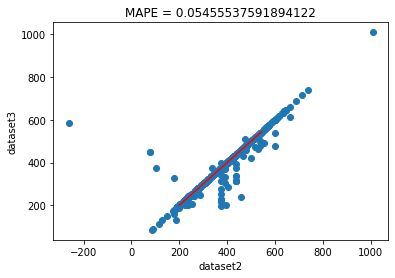

In [134]:
df1        = df_auto2[['SMILES','auto_temp_C']]
df2        = df_auto3[['SMILES','temp_C']]
overlap    = pd.merge(df1,df2,on='SMILES',how='inner')

x = overlap[list(overlap)[-1]].values
y = overlap[list(overlap)[-2]].values

plt.scatter(x,y)
plt.plot(np.arange(200,550,5),np.arange(200,550,5),c='r')
plt.xlabel('dataset2')
plt.ylabel('dataset3')
plt.title('MAPE = {}'.format(MAPE(x,y)))

In [135]:
len(df_auto3)

512

In [136]:
## Union between 4 datasets 

from functools import reduce

auto_t['temper_C'] = auto_t['Temp'].apply(lambda x:x-273)

dfs = [df_glass[['SMILES','lowest_rep_auto_temp_C']],df_notin_glass[['SMILES','lowest_rep_auto_temp_C_other']],\
                df_auto2[['SMILES','auto_temp_C']],\
               df_auto3[['SMILES','temp_C']],auto_t[['SMILES','temper_C']]]
       
df_final_auto = reduce(lambda left,right: pd.merge(left,right,on='SMILES',how='outer'), dfs)


In [137]:
cols_names = {'lowest_rep_auto_temp_C':'dataset1_in_glass',\
              'lowest_rep_auto_temp_C_other':'dataset1_out_glass',\
              'auto_temp_C':'dataset2',
              'temp_C':'dataset3','temper_C':
              'paper'}

df_final_auto = df_final_auto.rename(columns=cols_names)

In [138]:
### Check relations between columns on data with compounds overlap 

cols     = list(df_final_auto)
df_final_auto[(df_final_auto[cols[1]].notnull()) & (df_final_auto[cols[2]].notnull()) & \
              (df_final_auto[cols[3]].notnull()) & (df_final_auto[cols[4]].notnull()) &  (df_final_auto[cols[5]].notnull())]

,SMILES,dataset1_in_glass,dataset1_out_glass,dataset2,dataset3,paper
0,CC,515.0,472.0,471.9,515.000000,515.0
1,CCCC,372.0,450.0,287.9,405.000000,372.0
2,CCC,493.0,288.0,449.9,450.000000,450.0
3,CCCCC,258.0,243.0,242.9,260.000000,265.0
4,CCCCCC,227.0,225.0,224.9,233.888889,224.0
5,CCCCCCC,213.0,204.0,203.9,222.777778,213.0
10,CCCCCCCCCCCCCC,202.0,200.0,200.0,200.000000,220.0
12,CC(C)C,462.0,460.0,460.0,460.000000,460.0
17,CCCCCCC(C)C,227.0,220.0,220.0,220.000000,220.0
18,CCCCCC(C)CC,228.0,220.0,220.0,220.000000,220.0


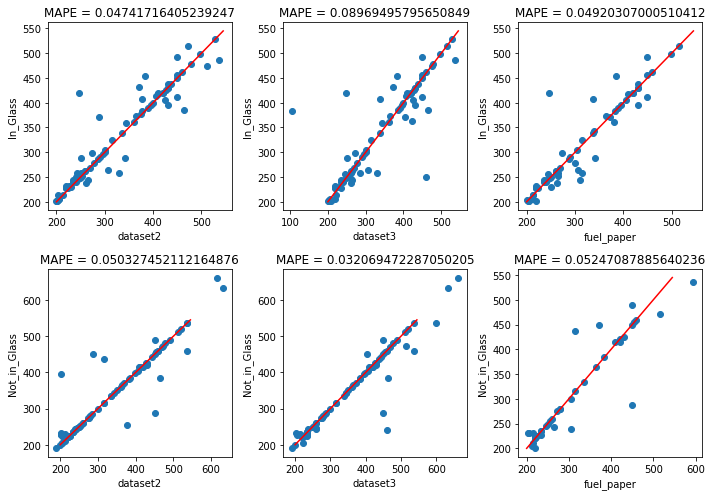

In [140]:
#### Find which columns belong to measuremnts in glass and out 

# In Glass AIT:  df1['lowest_rep_auto_temp_C']  ,  auto_t['temper_C' ] , df3['temp_C']
# Out Glass AIT:  df1['lowest_rep_auto_temp_C_other']  ,  df2['auto_temp_C']

fig,axes  = plt.subplots(2, 3, figsize=(10, 7))


'''In Glas Out glass Temp measuremnts'''

rows    = [df_glass[['SMILES','lowest_rep_auto_temp_C']],df_notin_glass[['SMILES','lowest_rep_auto_temp_C_other']]]
rows_n  = ['In_Glass','Not_in_Glass']

cols    = [df_auto2[['SMILES','auto_temp_C']],df_auto3[['SMILES','temp_C']], auto_t[['SMILES','temper_C']]]
cols_n  = ['dataset2','dataset3','fuel_paper']


for i in range(2):
    for j in range(3):
        df1        = rows[i]
        df2        = cols[j]
        overlap    = pd.merge(df1,df2,on='SMILES',how='inner')
        x = overlap[list(overlap)[-1]].values
        y = overlap[list(overlap)[-2]].values
        axes[i,j].scatter(x,y)
        axes[i,j].plot(np.arange(200,550,5),np.arange(200,550,5),c='r')
        axes[i,j].set_xlabel(cols_n[j])
        axes[i,j].set_ylabel(rows_n[i])
        axes[i,j].set_title('MAPE = {}'.format(MAPE(x,y)))
        
fig.tight_layout()     

In [141]:
#### Not in GLASS AIT looks overlaps better then in GLASS with other datasets
#### Impossible to determine whatever datasets columns belong to GLASS/Not Glass, since for example (above overlap plot)
### Priority to chose values from 4 datasets - used to select final AIT dataset
###               dataset1(clear AIT source,overlaps better then the GLASS with rest), lowest_rep_auto_temp_C_other
###               dataset3(ovelaps best with the first)                                temp_C 
###               dataset2                                                             auto_temp_C
###               paper   (not a coherent source)                                      temper_C

dfs = [df_notin_glass[['SMILES','lowest_rep_auto_temp_C_other']],\
                df_auto2[['SMILES','code','auto_temp_C']],\
               df_auto3[['SMILES','temp_C']],auto_t[['SMILES','temper_C']]]
       
df_final_auto = reduce(lambda left,right: pd.merge(left,right,on='SMILES',how='outer'), dfs)

###           not_in_glass                 
priority = ['lowest_rep_auto_temp_C_other','temp_C','auto_temp_C','temper_C']

df_final_auto = df_final_auto.fillna(0)

def AIT_select(X):
    
    if X[0] != 0:
        return X[0]
    elif X[1] != 0:
        return X[1]
    elif X[2] != 0:
        return X[2]
    else: 
        return X[3]

df_final_auto['AIT_C'] = df_final_auto[priority].apply(AIT_select,axis=1)

In [142]:
df_final_auto

,SMILES,lowest_rep_auto_temp_C_other,code,auto_temp_C,temp_C,temper_C,AIT_C
0,C,537.0,1.0,536.9,600.0,595.0,537.0
1,CC,472.0,1.0,471.9,515.0,515.0,472.0
2,CCCC,450.0,1.0,287.9,405.0,372.0,450.0
3,CCC,288.0,1.0,449.9,450.0,450.0,288.0
4,CCCCC,243.0,1.0,242.9,260.0,265.0,243.0
...,...,...,...,...,...,...,...
940,C/C=C/C(C)=C,0.0,0.0,0.0,0.0,308.0,308.0
941,C1CCCCCC=CCCCC1,0.0,0.0,0.0,0.0,258.0,258.0
942,CCCc1cccc2ccccc12,0.0,0.0,0.0,0.0,417.0,417.0
943,CCc1ccc(C=C)cc1,0.0,0.0,0.0,0.0,362.0,362.0


Text(0, 0.5, 'Dataset count')

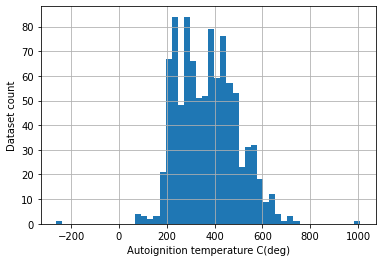

In [143]:
df_final_auto['AIT_C'].hist(bins=50)
plt.xlabel('Autoignition temperature C(deg)')
plt.ylabel('Dataset count')

In [144]:
print('Autoignition temperature dataset size = {}'.format(len(df_final_auto)))

Autoignition temperature dataset size = 945


In [145]:
df_final_auto.duplicated(subset='SMILES').sum()

1

In [147]:
df_final_auto[df_final_auto.duplicated(subset='SMILES')]

,SMILES,lowest_rep_auto_temp_C_other,code,auto_temp_C,temp_C,temper_C,AIT_C
302,CCc1ccccc1C,0.0,1.0,440.0,440.0,440.0,440.0


In [149]:
df_final_auto = df_final_auto.drop_duplicates(subset='SMILES')

In [151]:
df_final_auto.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\auto_temp.csv',index=False)

In [152]:
df_final_auto.shape

(944, 7)

In [257]:
priority = ['lowest_rep_auto_temp_C_other','temp_C','auto_temp_C','temper_C']
df_test['AIT_C'] = df_final_auto[priority].apply(AIT_select,axis=1)
merged_AIT_out_Glass_octane = pd.merge(octane,df_test,how='left',on='SMILES')['AIT_C'].isnull()
print('Number of missing compounds in octane if all AIT datasets merged with out_glass = {} out of 492'.format(len(merged_AIT_out_Glass_octane)))

Number of missing compounds in octane if all AIT datasets merged with out_glass = 526 out of 492


Text(0, 0.5, 'RON')

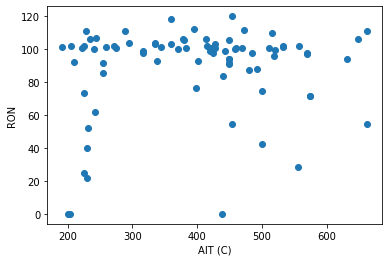

In [251]:
df_AIT_octane = pd.merge(octane,df_test,how='left',on='SMILES')
plt.scatter(df_AIT_octane.loc[df_AIT_octane['AIT_C'].notnull(),'AIT_C'],df_AIT_octane.loc[df_AIT_octane['AIT_C'].notnull(),'y'])
plt.xlabel('AIT (C)')
plt.ylabel('RON')

Text(0, 0.5, 'Count in AIT dataset')

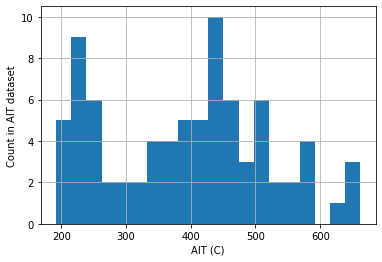

In [252]:
df_AIT_octane.loc[df_AIT_octane['AIT_C'].notnull(),'AIT_C'].hist(bins=20)
plt.xlabel('AIT (C)')
plt.ylabel('Count in AIT dataset')

# Enthalpy of combustion 

https://app.knovel.com/web/view/itable/show.v/rcid:kpYHTPPCC4/cid:kt003DPR12/viewerType:itble//root_slug:Enthalpy-of-Combustion-New/url_slug:enthalpy-combustion?b-content-type=itable&b-q=enthalpy%20of%20combustion&include_synonyms=no&q=enthalpy%20of%20combustion&sort_on=default&start=4950&columns=2,7,1,8,3,4,5,6

In [11]:
files_enthalpy = glob.glob(r"C:\Users\zcemg08\Desktop\data\enthalpy\*.csv")

In [12]:
header = ['compound','synonyms','formular','CAS Registry No.','phys_state','enthalpy of combustion@ 77Â°F (kJ/mol)',\
         'enthalpy of combustion (mass basis)@ 77Â°F (kJ/kg)','enthalpy of combustion(eng. basis)@ 77Â°F (Btu/lb)']

col         = [1,1,1,1,1,0,0,0]

skiprows    = [0,1,2,3,4,5,6,7,8,9]

df_enthalpy = pd.concat([clean_df(x,header,skiprows,col) for x in files_enthalpy])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [13]:
df_enthalpy.head(2)

,compound,synonyms,formular,CAS Registry No.,phys_state,enthalpy of combustion@ 77Â°F (kJ/mol),enthalpy of combustion (mass basis)@ 77Â°F (kJ/kg),enthalpy of combustion(eng. basis)@ 77Â°F (Btu/lb)
0,abietic acid,view synonyms,C20H30O2,514-10-3,gas,10960.0,36236.6,15579.2
1,acenaphthene,view synonyms,C12H10,83-32-9,solid,6013.6,38995.9,16765.5


In [14]:
### Find SMILES symbols for each row

df_enthalpy['SMILES']                                    = df_enthalpy['CAS Registry No.'].apply(cas_to_smiles)
df_enthalpy.loc[df_enthalpy['SMILES'].isnull(),'SMILES'] = df_enthalpy.loc[df_enthalpy['SMILES'].isnull(),'compound'].apply(name_to_smiles)
df_enthalpy.loc[df_enthalpy['SMILES'].isnull(),'SMILES'] = df_enthalpy.loc[df_enthalpy['SMILES'].isnull(),'compound'].apply(CIRconvert)

cond                           = (df_enthalpy['SMILES'].isnull()) & (df_enthalpy['CAS Registry No.'].notnull())
df_enthalpy.loc[cond,'SMILES'] = df_enthalpy.loc[cond,'CAS Registry No.'].apply(spider_CAS_to_smiles)

df_enthalpy.loc[df_enthalpy['SMILES'].isnull(),'SMILES'] = df_enthalpy.loc[df_enthalpy['SMILES'].isnull(),'compound'].apply(spider_CAS_to_smiles)


In [44]:
df_enthalpy[df_enthalpy['SMILES'].notnull()].to_csv(r'C:\Users\zcemg08\Desktop\phys_data\enthalpy_.csv',index=False)

In [21]:
df_enthalpy.head()

,compound,synonyms,formular,CAS Registry No.,phys_state,enthalpy of combustion@ 77Â°F (kJ/mol),enthalpy of combustion (mass basis)@ 77Â°F (kJ/kg),enthalpy of combustion(eng. basis)@ 77Â°F (Btu/lb),SMILES
0,abietic acid,view synonyms,C20H30O2,514-10-3,gas,10960.0,36236.6,15579.2,CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...
1,acenaphthene,view synonyms,C12H10,83-32-9,solid,6013.6,38995.9,16765.5,C1Cc2cccc3cccc1c23
2,acetal,view synonyms,C6H14O2,105-57-7,liquid,3565.0,30166.6,12969.5,CCOC(C)OCC
3,acetaldehyde,view synonyms,C2H4O,1975-07-19,gas,1104.4,25069.7,10778.2,CC=O
4,acetamide,view synonyms,C2H5NO,60-35-5,solid,999.6,16922.7,7275.6,CC(N)=O


In [11]:
df = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\enthalpy_.csv')

In [12]:
overlap = pd.merge(df[['SMILES','enthalpy of combustion (mass basis)@ 77Â°F (kJ/kg)']],\
                  comb_h,how='inner',on='SMILES')

Text(0.5, 1.0, 'Combustion heat (kJ/kg)')

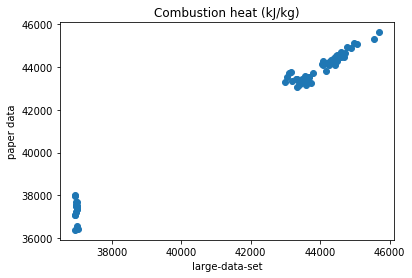

In [13]:
plt.scatter(overlap[list(overlap)[1]],overlap[list(overlap)[2]])
plt.xlabel('large-data-set')
plt.ylabel('paper data')
plt.title('Combustion heat (kJ/kg)')

In [27]:
cond = overlap[list(overlap)[2]] < 38000
x    = overlap.loc[cond,list(overlap)[1]].values
y    = overlap.loc[cond,list(overlap)[2]].values

print('MAPE beetween 2 sources of heat of combustion for heat_val <38000 is equal to {}'.format(MAPE(x,y)))

MAPE beetween 2 sources of heat of combustion for heat_val <38000 is equal to 0.01259845403103222


In [29]:
cond = overlap[list(overlap)[1]].notnull()
x    = overlap.loc[cond,list(overlap)[1]].values
y    = overlap.loc[cond,list(overlap)[2]].values

print('MAPE beetween 2 sources of heat of combustion for all heat_val is equal to {}'.format(MAPE(x,y)))

MAPE beetween 2 sources of heat of combustion for all heat_val is equal to 0.006447866833314981


### MAPE is too low, both data sets represent the same thing -> join them 

In [47]:
enthalpy_comb_total = pd.merge(df[['SMILES','enthalpy of combustion (mass basis)@ 77Â°F (kJ/kg)']],\
                  comb_h,how='outer',on='SMILES')

In [48]:
cols = list(enthalpy_comb_total)
cond = (enthalpy_comb_total[cols[1]].isnull()) & (enthalpy_comb_total[cols[2]].isnull())

print(len(enthalpy_comb_total[cond]))

146


In [49]:
### No point in empty values 
enthalpy_comb_total = enthalpy_comb_total[~cond]

In [50]:
def enthalpy_select(X):
    n,m = X[0],X[1]
    if m==0:
        return n
    else:
        return m

In [51]:
enthalpy_comb_total['Hc°(KJ/kg)'] = enthalpy_comb_total[[cols[1],cols[2]]].apply(enthalpy_select,axis=1)

Text(0, 0.5, 'Dataset count')

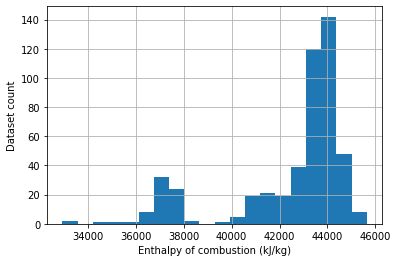

In [59]:
enthalpy_comb_total['Hc°(KJ/kg)'].hist(bins=20)
plt.xlabel('Enthalpy of combustion (kJ/kg)')
plt.ylabel('Dataset count')

In [61]:
print('Total enthalpy combustion dataset size = {}'.format(len(enthalpy_comb_total)))

Total enthalpy combustion dataset size = 5172


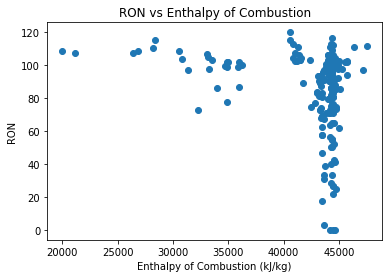

In [57]:
new_df = pd.merge(octane,enthalpy_comb_total,how='left',on='SMILES')

cond = new_df['enthalpy of combustion (mass basis)@ 77Â°F (kJ/kg)'].notnull()

x = new_df.loc[cond,'enthalpy of combustion (mass basis)@ 77Â°F (kJ/kg)']
y = new_df.loc[cond,'y']

plt.scatter(x,y)
plt.xlabel('Enthalpy of Combustion (kJ/kg)')
plt.ylabel('RON')
plt.title('RON vs Enthalpy of Combustion')
plt.show()

In [60]:
print('Enthalpy overlap with octane = {}'.format(len(new_df[cond])))

Enthalpy overlap with octane = 180


In [68]:
enthalpy_comb_total.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\enthalpy_.csv')

In [21]:
enthalpy_comb_total = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\enthalpy_.csv')

In [22]:
enthalpy_comb_total['Reid_pressure'] = enthalpy_comb_total.apply(get_antoine_coef,axis=1)

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

In [23]:
enthalpy_comb_total['Reid_pressure'].notnull().sum()

321

In [24]:
enthalpy_comb_total.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\enthalpy_.csv')

# Viscosity 

#### https://app.knovel.com/web/view/itable/show.v/rcid:kpYTPCHEE8/cid:kt0078W7R1/viewerType:eptble//root_slug:liquid-viscosities---organic-compounds/url_slug:liquid-viscosities-organic?b-toc-cid=kpYTPCHEE8&b-toc-root-slug=&b-toc-url-slug=liquid-viscosities-organic&b-toc-title=Yaws%27%20Transport%20Properties%20of%20Chemicals%20and%20Hydrocarbons%20(Electronic%20Edition)&start=7150&columns=1,2,3,4,5,6,7,8,9,10,11,12,13,14

In [17]:
files_viscosity = glob.glob(r"C:\Users\zcemg08\Desktop\data\viscosity\*.csv")

In [18]:
header = ['equation','compound','formula','CAS Registry No.','A','B','C','D','code',\
         'Tmin (K)','Tmax (K)','liquid viscosity @ Tmin (cP)','liquid viscosity @ 25Â°C (cP)','liquid viscosity @ Tmax (cP)']

col          = [1,1,1,1,0,0,0,0,1,0,0,0,0,0]
skiprows     = [0,1,2,3,4]

In [19]:
file_n         = r'C:\Users\zcemg08\Desktop\data\viscosity\TableData (11).csv'
file_y         = r'C:\Users\zcemg08\Desktop\data\viscosity\TableData (10).csv'

In [20]:
dfs        = []
left_files = []

for file in files_viscosity:
    try:
        df = clean_df(file,header,skiprows,col)
        dfs.append(df)
    except:
        left_files.append(file)

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [21]:
last_df = dfs[-1]

In [22]:
last_df = last_df.drop([3,4,5,6],axis=0)

In [23]:
dfs.pop(-1)

,equation,compound,formula,CAS Registry No.,A,B,C,D,code,Tmin (K),Tmax (K),liquid viscosity @ Tmin (cP),liquid viscosity @ 25Â°C (cP),liquid viscosity @ Tmax (cP)
0,,n-octanonacontane,C98H198,7670-26-0,47.8488,-14662.8,-0.045438,0.000012,2,686.0,2172.0,7.6989,None,0.022907
1,,n-nonanonacontane,C99H200,7670-27-1,54.1024,-16664.0,-0.051127,0.000013,2,687.0,2192.0,10.0274,None,0.022601
2,,n-hectane,C100H202,6703-98-6,61.5759,-19080.6,-0.057867,0.000015,2,688.0,2212.0,13.5389,None,0.022288
3,,,,,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,None,NaN
4,,,,,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,None,NaN
5,Yaws' Transport Properties of Chemicals and Hy...,,,,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,None,NaN
6,,,,,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,None,NaN


In [24]:
def clean_df2(link_,header,skiprows,col):
    
    df     = pd.read_csv(link_,skiprows=skiprows,header=None,sep='delimiter')
    df.drop(df.tail(3).index,inplace=True)
    
    def func_row(row):
        elements   = row.values[0].split(',')
        left,right = elements[:-12]    ,elements[-12:]
        eq   = left[0]
        if len(elements[:-12][1:]) > 1:
            name = ','.join(elements[:-12][1:])[1:-1]
        else:
            name = ','.join(elements[:-12][1:])
        return [eq,name] + right
    
    df[header] = df.apply(func_row,axis=1,result_type='expand')
    
    df = df.drop(0,axis=1)
    
    return df 

In [25]:
def clean_df3(link_,header,skiprows,col):
    
    df     = pd.read_csv(link_,skiprows=skiprows,header=None,sep='delimiter')
    df.drop(df.tail(3).index,inplace=True)
    
    def func_row(row):
        vals_    = row.values[0].split(';')
        if len(vals_)>26:
            vals_.pop(2)
        return [string_float(x,idx) for x,idx in zip(vals_,col)]
    
    df[header] = df.apply(func_row,axis=1,result_type='expand')
    
    df = df.drop(0,axis=1)
    
    return df 

In [26]:
dfs2        = []
left_files2 = []

for file in left_files:
    try:
        df = clean_df3(file,header,skiprows,col)
        dfs2.append(df)
    except:
        left_files2.append(file)

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
df3 = [clean_df2(x,header,skiprows,col) for x in left_files2]

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
df_viscosity = pd.concat(dfs + dfs2 + df3 + [last_df])

In [29]:
df_viscosity = df_viscosity.drop('equation',axis=1)

In [30]:
df_viscosity

,compound,formula,CAS Registry No.,A,B,C,D,code,Tmin (K),Tmax (K),liquid viscosity @ Tmin (cP),liquid viscosity @ 25Â°C (cP),liquid viscosity @ Tmax (cP)
0,vinylacetylene,C4H4,689-97-4,-2.48677,312.066,0.0048235,-8.33623e-06,2,182,431,0.674758,0.180715,0.0584051
1,succinonitrile,C4H4N2,110-61-2,-12.5994,2428.1,0.0226886,-1.59796e-05,2,384,732,1.21005,NaN,0.0583473
2,furan,C4H4O,110-00-9,-3.6715,559.58,0.0074026,-9.7493e-06,"1,2",220,490,1.06844,0.35138,0.0571435
3,diketene,C4H4O2,674-82-8,-5.09541,900.3,0.00936418,-8.74132e-06,2,300,585,0.849925,NaN,0.0849996
4,succinic anhydride,C4H4O3,108-30-5,-11.9355,2504.2,0.0203663,-1.34968e-05,2,429,770,1.43035,NaN,0.0987103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,"1,3-dibromobutane",C4H8Br2,107-80-2,-4.26062,854.506,0.00696925,-6.04E-06,2,291,639,1.55158,1.40071,0.115996
48,"1,4-dibromobutane",C4H8Br2,110-52-1,-4.60545,959.636,0.00728907,-5.94E-06,2,310,664,1.51092,,0.115083
0,n-octanonacontane,C98H198,7670-26-0,47.8488,-14662.8,-0.0454381,1.18608e-05,2,686,2172,7.6989,None,0.0229068
1,n-nonanonacontane,C99H200,7670-27-1,54.1024,-16664,-0.0511273,1.33045e-05,2,687,2192,10.0274,None,0.0226007


In [31]:
for col in list(df_viscosity):
    print(col +' ' + 'miss val = {}'.format(df_viscosity[col].isnull().sum()))

compound miss val = 0
formula miss val = 0
CAS Registry No. miss val = 0
A miss val = 0
B miss val = 0
C miss val = 0
D miss val = 0
code miss val = 0
Tmin (K) miss val = 0
Tmax (K) miss val = 0
liquid viscosity @ Tmin (cP) miss val = 0
liquid viscosity @ 25Â°C (cP) miss val = 3313
liquid viscosity @ Tmax (cP) miss val = 0


<AxesSubplot:>

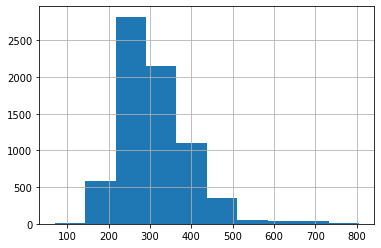

In [32]:
df_viscosity['Tmin (K)'].astype('float32').hist()

In [33]:
col_change_dtype = ['A','B','C','D']
df_viscosity     = df_viscosity.astype({col:'float32' for col in col_change_dtype})

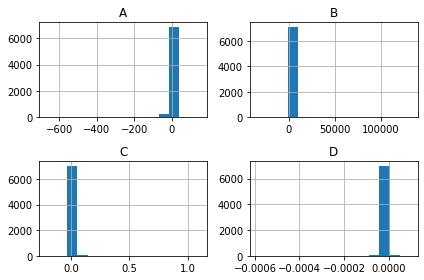

In [34]:
df_viscosity[col_change_dtype].hist(bins=15)
plt.tight_layout()

In [35]:
df_viscosity['SMILES'] = df_viscosity['CAS Registry No.'].apply(cas_to_smiles)

In [39]:
df_viscosity[df_viscosity['SMILES'].isnull()]

,compound,formula,CAS Registry No.,A,B,C,D,code,Tmin (K),Tmax (K),liquid viscosity @ Tmin (cP),liquid viscosity @ 25Â°C (cP),liquid viscosity @ Tmax (cP),SMILES
30,"1,3-dichloro-1-butene",C4H6Cl2,52497-07-1,-5.419280,911.026978,0.010969,-0.000010,2,282,608,1.18,0.945118,0.0751082,None
31,"2,3-dichloro-1-butene",C4H6Cl2,7013-11-08,-5.594080,933.318970,0.011415,-0.000011,2,279,608,1.24337,0.947327,0.0751082,None
32,"1,1-dichloro-2-butene",C4H6Cl2,56800-09-0,-5.422070,910.497986,0.011005,-0.000011,2,282,608,1.17991,0.949005,0.0751082,None
35,"cis-2,3-dichloro-2-butene",C4H6Cl2,1587-26-4,-5.375620,908.041016,0.010771,-0.000010,2,282,608,1.164,0.932829,0.0751082,None
36,"trans-2,3-dichloro-2-butene",C4H6Cl2,1587-29-7,-5.787110,958.651001,0.011874,-0.000011,2,276,608,1.28945,0.942898,0.0751082,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,"1,2,3-triiodo-2-methylpropane",C4H7I3,,-5.281630,1246.270020,0.008357,-0.000006,2,375,824,2.21949,,0.129702,None
28,"1,3-diiodo-2-(iodomethyl)-propane",C4H7I3,,-5.263030,1232.290039,0.008314,-0.000006,2,363,814,2.373,,0.130336,None
0,n-octanonacontane,C98H198,7670-26-0,47.848801,-14662.799805,-0.045438,0.000012,2,686,2172,7.6989,None,0.0229068,None
1,n-nonanonacontane,C99H200,7670-27-1,54.102402,-16664.000000,-0.051127,0.000013,2,687,2192,10.0274,None,0.0226007,None


In [43]:
df_viscosity[df_viscosity['SMILES'].isnull()].iloc[0]

compound                         1,3-dichloro-1-butene
formula                                        C4H6Cl2
CAS Registry No.                            52497-07-1
A                                             -5.41928
B                                              911.027
C                                             0.010969
D                                          -1.0476e-05
code                                                 2
Tmin (K)                                           282
Tmax (K)                                           608
liquid viscosity @ Tmin (cP)                      1.18
liquid viscosity @ 25Â°C (cP)                 0.945118
liquid viscosity @ Tmax (cP)                 0.0751082
SMILES                                            None
Name: 30, dtype: object

In [44]:
name_to_smiles(df_viscosity[df_viscosity['SMILES'].isnull()].iloc[0].compound)

'CC(C=CCl)Cl'

In [42]:
cas_to_smiles('52497-07-1')

In [45]:
df_viscosity.loc[df_viscosity['SMILES'].isnull(),'SMILES'] = df_viscosity.loc[df_viscosity['SMILES'].isnull(),'compound'].apply(name_to_smiles)


In [46]:
df_viscosity.loc[df_viscosity['SMILES'].isnull()]

,compound,formula,CAS Registry No.,A,B,C,D,code,Tmin (K),Tmax (K),liquid viscosity @ Tmin (cP),liquid viscosity @ 25Â°C (cP),liquid viscosity @ Tmax (cP),SMILES
36,"trans-2,3-dichloro-2-butene",C4H6Cl2,1587-29-7,-5.787110,958.651001,0.011874,-0.000011,2,276,608,1.28945,0.942898,0.0751082,None
1,"3-methyl-4,4-diethylhexane",C11H24,61868-71-1,-4.066530,713.390991,0.006691,-0.000007,2,266,612,0.85263,0.549544,0.0555695,None
2,"2,2,3-trimethyl-3-ethylhexane",C11H24,61868-72-2,-4.442550,761.331970,0.007796,-0.000008,2,277,607,0.764237,0.574992,0.0554091,None
3,"2,2,3-trimethyl-4-ethylhexane",C11H24,61868-73-3,-4.055070,683.114990,0.006996,-0.000007,2,252,598,0.940972,0.494339,0.0557639,None
5,"2,2,4-trimethyl-4-ethylhexane",C11H24,61868-75-5,-4.569530,773.020996,0.008220,-0.000008,2,276,604,0.769102,0.575417,0.05545,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,"1,2,3-triiodo-2-methylpropane",C4H7I3,,-5.281630,1246.270020,0.008357,-0.000006,2,375,824,2.21949,,0.129702,None
28,"1,3-diiodo-2-(iodomethyl)-propane",C4H7I3,,-5.263030,1232.290039,0.008314,-0.000006,2,363,814,2.373,,0.130336,None
0,n-octanonacontane,C98H198,7670-26-0,47.848801,-14662.799805,-0.045438,0.000012,2,686,2172,7.6989,None,0.0229068,None
1,n-nonanonacontane,C99H200,7670-27-1,54.102402,-16664.000000,-0.051127,0.000013,2,687,2192,10.0274,None,0.0226007,None


In [50]:
df_viscosity.loc[df_viscosity['SMILES'].isnull()].iloc[10]

compound                         2,2,4-trimethyl-3-isopropylpentane
formula                                                      C11H24
CAS Registry No.                                         61868-90-4
A                                                          -3.97472
B                                                           658.282
C                                                        0.00692186
D                                                      -7.08546e-06
code                                                              2
Tmin (K)                                                        239
Tmax (K)                                                        594
liquid viscosity @ Tmin (cP)                                1.07397
liquid viscosity @ 25Â°C (cP)                               0.46459
liquid viscosity @ Tmax (cP)                              0.0557977
SMILES                                                         None
Name: 23, dtype: object

In [51]:
df_viscosity.loc[df_viscosity['SMILES'].isnull(),'SMILES'] = df_viscosity.loc[df_viscosity['SMILES'].isnull(),'compound'].apply(CIRconvert)


In [88]:
len(df_viscosity.loc[df_viscosity['SMILES'].isnull()])

227

In [89]:
df_viscosity.head()

,compound,formula,CAS Registry No.,A,B,C,D,code,Tmin (K),Tmax (K),liquid viscosity @ Tmin (cP),liquid viscosity @ 25Â°C (cP),liquid viscosity @ Tmax (cP),SMILES
0,vinylacetylene,C4H4,689-97-4,-2.48677,312.066010,0.004823,-0.000008,2,182,431,0.674758,0.180715,0.0584051,C=CC#C
1,succinonitrile,C4H4N2,110-61-2,-12.59940,2428.100098,0.022689,-0.000016,2,384,732,1.21005,NaN,0.0583473,N#CCCC#N
2,furan,C4H4O,110-00-9,-3.67150,559.580017,0.007403,-0.000010,"1,2",220,490,1.06844,0.35138,0.0571435,o1cccc1
3,diketene,C4H4O2,674-82-8,-5.09541,900.299988,0.009364,-0.000009,2,300,585,0.849925,NaN,0.0849996,C=C1CC(=O)O1
4,succinic anhydride,C4H4O3,108-30-5,-11.93550,2504.199951,0.020366,-0.000013,2,429,770,1.43035,NaN,0.0987103,O=C1CCC(=O)O1


In [164]:
df_viscosity.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\viscosity.csv',index=False)

In [161]:
df_viscosity = df_viscosity.drop_duplicates(subset='SMILES')

In [153]:
df_viscosity = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\viscosity.csv')

In [165]:
df_viscosity.shape

(6660, 14)

### Some molecules have the same smiles, but different CAS Registry No. and coefs. a,b,c,d. The duplicated SMILES entries were removed anyway 

In [160]:
df_viscosity[df_viscosity['SMILES']=='C\C=C\C']

,compound,formula,CAS Registry No.,A,B,C,D,code,Tmin (K),Tmax (K),liquid viscosity @ Tmin (cP),liquid viscosity @ 25Â°C (cP),liquid viscosity @ Tmax (cP),SMILES
7140,2-butene,C4H8,107-01-7,-2.86623,327.671,0.006603,-0.000011,2,167,404,0.759984,0.152783,0.055425,C\C=C\C
7142,trans-2-butene,C4H8,624-64-6,-7.94610,813.340,0.024583,-0.000032,1;2,200,429,0.569849,0.183437,0.039808,C\C=C\C


In [159]:
df_viscosity[df_viscosity['SMILES']=='OC(=O)\C=C\C(O)=O']

,compound,formula,CAS Registry No.,A,B,C,D,code,Tmin (K),Tmax (K),liquid viscosity @ Tmin (cP),liquid viscosity @ 25Â°C (cP),liquid viscosity @ Tmax (cP),SMILES
5,fumaric acid,C4H4O4,110-17-8,-173.8670,36957.00,0.276335,-0.000149,2,561,732,1.24772,NaN,0.095026,OC(=O)\C=C\C(O)=O
6,maleic acid,C4H4O4,110-16-7,-28.0836,5937.31,0.045436,-0.000027,2,444,734,1.59882,NaN,0.095256,OC(=O)\C=C\C(O)=O


In [26]:
df_viscosity['Reid_pressure'] = df_viscosity.apply(get_antoine_coef,axis=1)

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

### Reid vapour pressure 

In [3]:
df_viscosity        = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\viscosity.csv')
enthalpy_comb_total = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\enthalpy_.csv')
data_auto1          = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\auto_combine1.csv')
bp_data             = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\boiling_point.csv')
octane              = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')

In [19]:
df_viscosity['Reid_pressure'] = df_viscosity.apply(get_antoine_coef,axis=1)

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

In [20]:
octane['Reid_pressure'] = octane.apply(get_antoine_coef,axis=1)

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

In [21]:
files_ = [octane,df_viscosity,bp_data,data_auto1,enthalpy_comb_total]

In [25]:
pd_reid_pressure = pd.concat([df.loc[df['Reid_pressure'].notnull(),['SMILES','Reid_pressure']] for df in files_])

In [28]:
pd_reid_pressure = pd_reid_pressure.drop_duplicates(subset='SMILES')

In [31]:
pd_reid_pressure.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\reid_pressure.csv')

# Density 

In [48]:
df_paper  = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\density.csv')
df1       = df_paper[['Smiles','Density (g/mL)']]
df1       = df1.rename(columns={'Smiles':'SMILES'})
df1       = df1.drop_duplicates(subset='SMILES')

df_knovel = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\bp_density_knovel.csv')
df2       = df_knovel[df_knovel['density (g/cm3)'].notnull()][['SMILES','density (g/cm3)']]
df2       = df2.drop_duplicates(subset='SMILES')

In [52]:
print(len(df1),len(df2))

492 3510


In [53]:
df1.head(3)

,SMILES,Density (g/mL)
0,CC(C)CC(C)C,0.673000
1,CCCCCCC,0.678688
2,CC(C)(C)C(C)C,0.679811


In [54]:
df2.head(3)

,SMILES,density (g/cm3)
2,CCOC(C)OCC,0.821
3,CC=O,0.774
6,CC(O)=O,1.043


In [55]:
df_density = pd.merge(df1,df2,on='SMILES',how='outer')

In [56]:
df_density

,SMILES,Density (g/mL),density (g/cm3)
0,CC(C)CC(C)C,0.673000,0.6680
1,CCCCCCC,0.678688,0.6820
2,CC(C)(C)C(C)C,0.679811,NaN
3,CCC(C)(C)CC,0.680891,0.6870
4,CC(C)C(C)CC,0.677702,NaN
...,...,...,...
3925,CCC(C)CC(C)CCC(C)C,NaN,0.7484
3926,CCCC(C)C(C)CCC(C)C,NaN,0.7545
3927,CCCCCC(C)C(C)C(C)C,NaN,0.7612
3928,CCCCC(C)CC(C)(C)CC,NaN,0.7548


In [57]:
cond = (df_density['Density (g/mL)'].notnull()) & (df_density['density (g/cm3)'])

y1 = df_density[cond][list(df_density)[1]]
y2 = df_density[cond][list(df_density)[2]]
MAPE(y1,y2)

0.013280555027871592

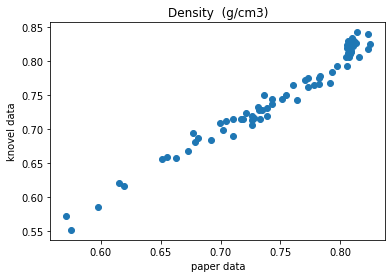

In [58]:
plt.scatter(y1,y2)
plt.title('Density  (g/cm3)')
plt.xlabel('paper data')
plt.ylabel('knovel data')
plt.show()

In [59]:
df_density = df_density.fillna(0)

def select_den(X):
    if X[1] !=0:
        return X[1]
    else:
        return X[0]

In [60]:
df_density['ro_(g/cm3)'] = df_density[['Density (g/mL)','density (g/cm3)']].apply(select_den,axis=1)

In [61]:
df_density

,SMILES,Density (g/mL),density (g/cm3),ro_(g/cm3)
0,CC(C)CC(C)C,0.673000,0.6680,0.668000
1,CCCCCCC,0.678688,0.6820,0.682000
2,CC(C)(C)C(C)C,0.679811,0.0000,0.679811
3,CCC(C)(C)CC,0.680891,0.6870,0.687000
4,CC(C)C(C)CC,0.677702,0.0000,0.677702
...,...,...,...,...
3925,CCC(C)CC(C)CCC(C)C,0.000000,0.7484,0.748400
3926,CCCC(C)C(C)CCC(C)C,0.000000,0.7545,0.754500
3927,CCCCCC(C)C(C)C(C)C,0.000000,0.7612,0.761200
3928,CCCCC(C)CC(C)(C)CC,0.000000,0.7548,0.754800


Text(0, 0.5, 'smaple count')

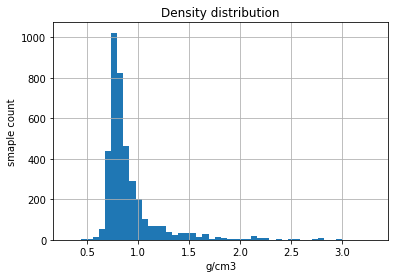

In [62]:
plt.title('Density distribution')
df_density['ro_(g/cm3)'].hist(bins=50)
plt.xlabel('g/cm3')
plt.ylabel('smaple count')

In [63]:
df_density.duplicated('SMILES').sum()

0

In [66]:
df_density[['SMILES','ro_(g/cm3)']].to_csv(r'C:\Users\zcemg08\Desktop\phys_data\density.csv',index=False)

# Reid Vapour Pressure

In [8]:
octane = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\octane_data.csv')
boil_p = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\boiling_point.csv')
auto_t = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\auto_temp\combined_auto_temp.csv')
enth_c = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\enthalpy_.csv')
densit = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\density.csv')
viscos = pd.read_csv(r'C:\Users\zcemg08\Desktop\phys_data\viscosity.csv')

In [14]:
dfs = [octane,boil_p,auto_t,enth_c,densit,viscos]

In [16]:
smiles = pd.concat([x['SMILES'] for x in dfs])
smiles = smiles.drop_duplicates()

In [23]:
rvp           = pd.DataFrame()
rvp['SMILES'] = smiles.values
rvp           = rvp.astype({'SMILES':str})

In [25]:
rvp['Reid_pressure'] = rvp.apply(get_antoine_coef,axis=1)

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not exist in the Data Base, Temperature
Sorry, the data for the given temperature {0}K does                        not e

In [26]:
rvp.to_csv(r'C:\Users\zcemg08\Desktop\phys_data\reid_pressure.csv',index=False)